In [1]:
import pandas as pd
from numpy import nan
import tlsh
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import sys; sys.path.insert(0, '..') # Allow relative imports

from scanner.Detection.ClusteringBased.Clustering.DBSCANClustering import DBSCANClustering
from scanner.Detection.ClusteringBased.Clustering.KMedoidsClustering import KMedoidsClustering
from scanner.Detection.ClusteringBased.Clustering.OPTICSClustering import OPTICSClustering
from scanner.Utilities.Util import random_string
from scanner.Utilities.Distance import Distance

# TLSH Caveat

In [3]:
data = "test"

In [4]:
# No padding and not enough data
padding_length = 0
padding = padding_length * "*"
for_hashing = padding + data

tlsh_hash = tlsh.hash(for_hashing.encode())
print("Data: ", data)
print("Padding: ", padding)
print("Hash:", tlsh_hash)

Data:  test
Padding:  
Hash: TNULL


In [5]:
# With padding but too similar data
padding_length = 50
padding = padding_length * "*"
for_hashing = padding + data

tlsh_hash = tlsh.hash(for_hashing.encode())
print("Data: ", data)
print("Padding: ", padding)
print("Hash:", tlsh_hash)

Data:  test
Padding:  **************************************************
Hash: TNULL


In [6]:
# Solution: Padding is random generated string

padding = random_string(padding_length)
for_hashing = padding + data

tlsh_hash = tlsh.hash(for_hashing.encode())
print("Data: ", data)
print("Padding: ", padding)
print("Hash:", tlsh_hash)

Data:  test
Padding:  7KKWAI1LOB41VFT1W44SOYXYXQQL0QGIN8BZNLSBP4WJB2PEGK
Hash: T1369002B666D265502166A031F1800D555861801255505569135854517050866217E974


# Distance calculation

In [7]:
padding = random_string(padding_length)

In [8]:
default_distance_type = "tlsh"

In [9]:
hash_1 = tlsh.hash(("test" + padding).encode())
hash_2 = tlsh.hash(("test2" + padding).encode())
distance = Distance().calculate(hash_1, hash_2, default_distance_type)

print("Hash 1:", hash_1)
print("Hash 2:", hash_2)
print("Distance:",distance)

Hash 1: T16690026514455DC0351A6BA027675BE6214590801A2D1E65804983C90942964D486142
Hash 2: T15D90025414056E80351A67A0236B5BA6214590811A2D1E65404DC3C509429659586152
Distance: 20


In [10]:
hash_3 = tlsh.hash((padding + "something completely different").encode())
distance = Distance().calculate(hash_1, hash_3, default_distance_type)
print("Hash 3:", hash_3)
print("Distance:",distance)

Hash 3: T14CA0244401055C40371D135033130FF5300FD040173D3F311005C3C005C1D50C0C50C5
Distance: 99


In [11]:
hash_4 = tlsh.hash((padding + "lets add another cluster").encode())

# Create a dummy dataset

In [12]:
def create_dummy_dataset(hashes, labels):
    dataset = []
    for idx, tlsh_hash in enumerate(hashes):
        dataset.append({"hash":tlsh_hash, "label":labels[idx]})
    return dataset

In [13]:
hashes = []
labels = []

hashes.append(hash_1)
labels.append(0)

hashes.append(hash_2)
labels.append(0)

hashes.append(hash_3)
labels.append(1)

hashes.append(hash_4)
labels.append(2)

dataset = create_dummy_dataset(hashes, labels)

In [14]:
from scanner.Utilities.Distance import Distance
import seaborn as sns

distance_matrix = Distance.generate_distance_matrix(dataset, field_for_index=None, distance_type=default_distance_type)
distance_matrix.head()

100%|██████████████████████████████████████████| 4/4 [00:00<00:00, 29799.67it/s]


,0,1,2,3
0,0,20,99,86
1,20,0,100,91
2,99,100,0,135
3,86,91,135,0


<AxesSubplot:>

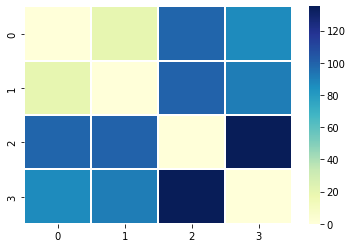

In [15]:
plt.figure()
sns.heatmap(distance_matrix, linewidth=0.1, cmap="YlGnBu")

# Clustering

### DBSCAN short example

In [16]:
dbscan = DBSCANClustering()
cluster_count, cluster_labels = dbscan.cluster(dataset, field_for_index=None, distance_type=default_distance_type)

print("Cluster count:", cluster_count)
for idx, item in enumerate(hashes):
    print("Hash", item, "clustered in label:", cluster_labels[idx], "actual:", labels[idx])

100%|██████████████████████████████████████████| 4/4 [00:00<00:00, 30393.51it/s]

Cluster count: 3
Hash T16690026514455DC0351A6BA027675BE6214590801A2D1E65804983C90942964D486142 clustered in label: 0 actual: 0
Hash T15D90025414056E80351A67A0236B5BA6214590811A2D1E65404DC3C509429659586152 clustered in label: 0 actual: 0
Hash T14CA0244401055C40371D135033130FF5300FD040173D3F311005C3C005C1D50C0C50C5 clustered in label: 1 actual: 1
Hash T1F6A022BC02023CC23C2AF3B023338BF3200080822B3C0FBA800883C80803C30B082002 clustered in label: 2 actual: 2


# Clustering Performance

In [17]:
from dataclasses import dataclass
from dataclasses_json import dataclass_json

@dataclass_json
@dataclass
class ClusteringResult:
    method: str
    parameter: str
    value: any
    similarity_metric: str
    clusters: int
    
    def __lt__(self, other):
         return self.clusters < other.clusters

def print_results(results:[ClusteringResult], actual_cluster_count):
    print("Actual cluster count:", actual_cluster_count)
    results_as_dicts = [result.to_dict() for result in results]
    
    custom_columns = ["Clustering method", "Optimized parameter", "Optimization type", "Similarity Metric", "Clusters detected"]
    df = pd.DataFrame(results_as_dicts)
    df.columns = custom_columns
    display(df.style)
    
overal_results: [ClusteringResult] = []

Idea: Generate cluster seeds i.e. clusters. Afterwards extend each seed with a random data with random lenght (i.e. create dispersed samples around the cluster seed). 

This function generates mock data similar to the one which our crawler should be generating. This however doesn't corresponds 100% to the reality. The caveat here is the random data appended to the cluster seed and it's length. Those parameters affect how good our clustering algorithms are going to detect the separate clusters. Samples generated too far from the cluster seed could actually on the boundry between two clusters, in the region of another cluster or just be too far from all other points and create a cluster on its own (i.e. outliers are not excluded). We use this example only for simple benchmarking and PoC.

In [18]:
import random

def generate_random_clusters(cluster_count, datapoints_count):
    cluster_seeds = []

    for cluster in range(cluster_count):
        cluster_seeds.append(random_string(200))
    
    dataset = None
    if datapoints_count >= cluster_count:
        hashes = []
        labels = []
        for idx in range(datapoints_count):
            seed = random.choice(cluster_seeds)
            random_str_length = random.randint(0,5)
            datapoint_data = random_string(random_str_length)
            datapoint_hash = tlsh.hash((datapoint_data + seed).encode())
            hashes.append(datapoint_hash)
            labels.append(cluster_seeds.index(seed))
        dataset = create_dummy_dataset(hashes, labels)
    
    return dataset

# Generate data and plot it

In [19]:
target_cluster_count = 10
target_datapoints = 100
dataset = generate_random_clusters(cluster_count=target_cluster_count, datapoints_count=target_datapoints)

In [20]:
distance_matrix = Distance.generate_distance_matrix(dataset, field_for_index=None, distance_type=default_distance_type)

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 4357.76it/s]


### Note: 2d scatter plot is directly not possible

We don't have the exact sample coordinates, but only their distances. This is also the reason why we use the upcoming algorithms.
They can be directly utilized with a precomputed distance matrix, which we already have. For the others, the exact x and y coordinates are needed. 
Given the nature of our problem, the x and y coordinates of the samples are ambiguous (string distance), but there is a method to calculate them. 
A simple google search leads to a solution which still has to be explored: https://math.stackexchange.com/questions/156161/finding-the-coordinates-of-points-from-distance-matrix


<AxesSubplot:>

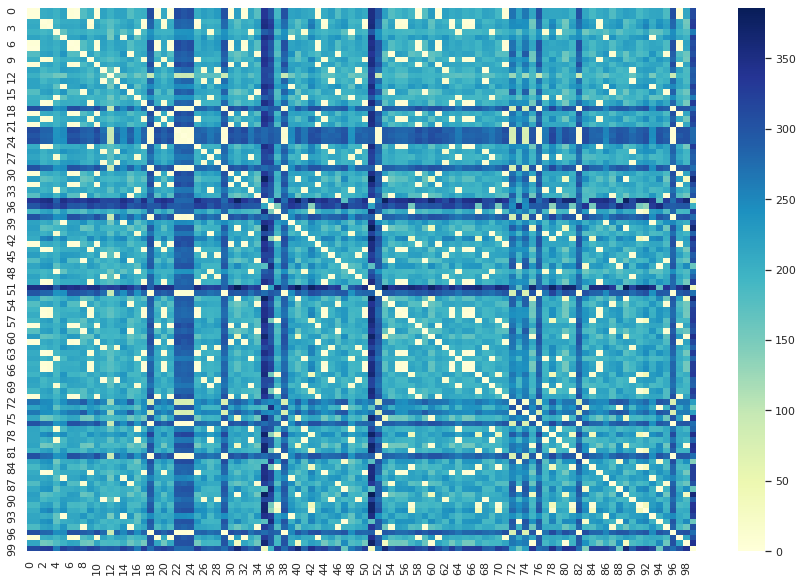

In [21]:
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(distance_matrix, cmap="YlGnBu")

### DBSCAN with differen methods for eps estimation

In [22]:
dbscan_results = []

# Manual eps
manual_eps = 20
manual_eps_clusters, manual_eps_labels = dbscan.cluster(dataset, field_for_index=None, eps=manual_eps, distance_type=default_distance_type)
dbscan_results.append(ClusteringResult(method="DBSCAN", parameter="eps",value=str(manual_eps) + " (manual value)",clusters=manual_eps_clusters, similarity_metric=default_distance_type))

# Eps detection using knee method
knee_eps_clusters, knee_eps_labels = dbscan.cluster(dataset, field_for_index=None, eps='knee', distance_type=default_distance_type)
dbscan_results.append(ClusteringResult(method="DBSCAN", parameter="eps", value="knee (auto)", clusters=knee_eps_clusters, similarity_metric=default_distance_type))

# Eps detection using knee method from kneed library
knee_lib_eps_clusters, knee_lib_eps_labels = dbscan.cluster(dataset, field_for_index=None, eps='kneed_lib', distance_type=default_distance_type)
dbscan_results.append(ClusteringResult(method="DBSCAN", parameter="eps", value="kneedlib (auto)", clusters=knee_lib_eps_clusters, similarity_metric=default_distance_type))

# Eps detection using silhouette_score (Default value)
sil_score_eps_clusters, sil_score_eps_labels = dbscan.cluster(dataset, field_for_index=None, eps='sil', distance_type=default_distance_type)
dbscan_results.append(ClusteringResult(method="DBSCAN", parameter="eps", value="silhouette_score (auto)", clusters=sil_score_eps_clusters, similarity_metric=default_distance_type))

overal_results.extend(dbscan_results)

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 3729.30it/s]


In [23]:
print_results(dbscan_results, target_cluster_count)

Actual cluster count: 10


,Clustering method,Optimized parameter,Optimization type,Similarity Metric,Clusters detected
0,DBSCAN,eps,20 (manual value),tlsh,1
1,DBSCAN,eps,knee (auto),tlsh,13
2,DBSCAN,eps,kneedlib (auto),tlsh,23
3,DBSCAN,eps,silhouette_score (auto),tlsh,14


# Plot clusters

When ploting the clusters, it should be taken into account that our data has already a reduced dimentionality. As already mentioned, the x and y coordinates are not present, instead we have the distances between each sample. 

Lets check the following trivial case:

1. We have 3 dummy samples representing our cluster centers (i.e. whe have 3 cluster), for which the x and y coordinates are present:

| Sample | X  | Y  |
|--------|----|----|
| First  | 0  | 0  |
| Second | 2  | 2  |
| Third  | -2 | -2 |

2. We calculate the euclidean distances between the 3 sample points which results in the following distance matrix:

| Sample | First  | Second  | Third  |
|--------|--------|---------|--------|
| First  | 0      | 2       | 2      | 
| Second | 2      | 0       | 4      | 
| Third  | 2      | 4       | 0      | 

3. Now we forget about the x and y coordinates which leaves us with the distance matrix only which represents our current problem.

4. If we try to plot all of the clusters by using the only first sample as a refference for all of the distances, we see a problem.
Even though the second and third samples are separate clusters, their euclidean distances from the first sample are the same, which 
will result in overlapping points on the plot. This however is only a problme in the graphical presentation of the data. For the clustering
algorithms this is irrelevant, because they use the whole distance matrix (i.e. the relative distances from each to every other point)
when determening the cluster of a sample. To avoid the described problem we should do the same when presenting the data i.e. we should 
add more dimensions to the plot to separate clusters with similar distances but different x and y coordinates.

Note (Nikolay): This somehow feels like the reverse process PCA, which I'm not sure if in our case it's possible, because we are missing some 
data for the reconstruction. Also you'll see in the following examples that when ploting in 3D some of the overlapping clusters get separated,
but others are still overlapping, which as far as I understand means, that we need more dimensions to propperly present the data.


## The silhoutte score returns the most promising results therefore the clustering results with this method here

In [24]:
# Generate random colors for each cluster
random_colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(sil_score_eps_clusters)]

# Plot clusters using the distances relative to the first sample as x and relative to the second as y value

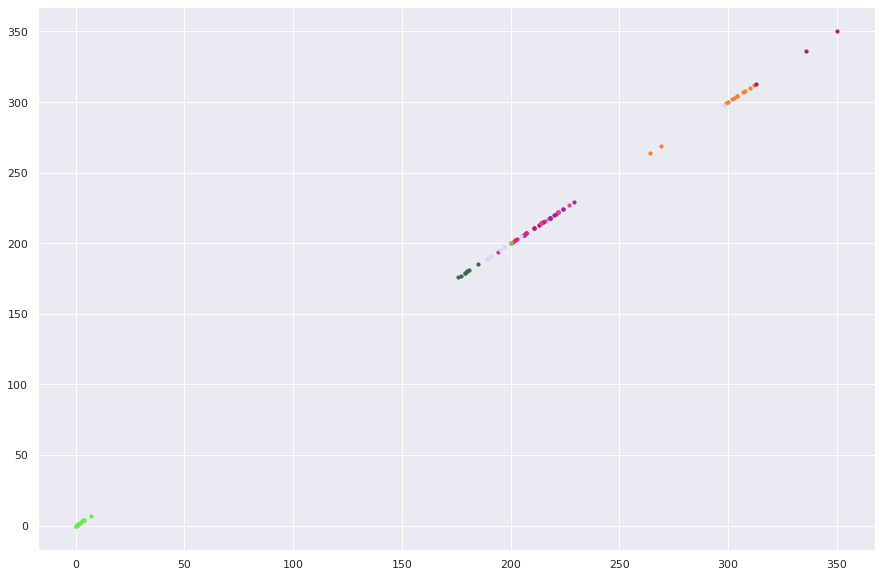

In [25]:
sample_colors = []
for sample in dataset:
    sample_colors.append(random_colors[sample['label']])  

plt.figure()
for idx in range(len(distance_matrix[0])):
    x = distance_matrix[0][idx]
    y = distance_matrix[1][idx]
    plt.scatter(x, y, s=10, c=sample_colors[idx])  # Plot a line at each location specified in a
plt.show()

# Plot clusters using the distances relative to the first sample as x, relative to the second as y value and relative to the third as z value

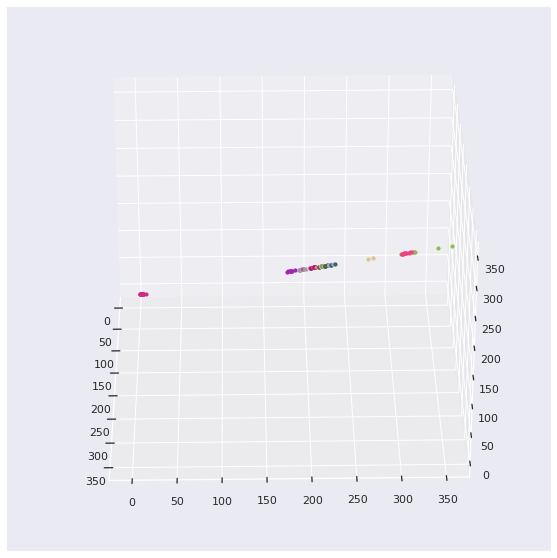

In [26]:
sample_colors = []
for label in sil_score_eps_labels:
    sample_colors.append(random_colors[label])  
    
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for idx in range(len(distance_matrix[0])):
    x = distance_matrix[0][idx]
    y = distance_matrix[1][idx]
    z = distance_matrix[1][idx]
    ax.scatter(x, y, z, s=10, c=sample_colors[idx])  # Plot a line at each location specified in a

# rotate the axes and update
for angle in range(0, 360):
    ax.view_init(30, angle)
plt.show()

### OPTICS with 

In [27]:
# OPTICS with different min sample count

optics = OPTICSClustering()

optics_resuls = []
for min_sample in range (2,10):
    clusters, labels = optics.cluster(dataset, field_for_index=None, min_sample=min_sample, distance_type=default_distance_type)
    optics_resuls.append(ClusteringResult(method="OPTICS",parameter="min_sample",value=str(min_sample) + " (manual value)",clusters=clusters, similarity_metric=default_distance_type))

overal_results.extend(optics_resuls)

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 4517.05it/s]
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/cluster/_optics.py:903: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
100%|███████████████████████████████████████| 100/100 [00:00<00:00, 4348.77it/s]
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/cluster/_optics.py:903: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2666.52it/s]


In [28]:
print_results(optics_resuls, target_cluster_count)

Actual cluster count: 10


,Clustering method,Optimized parameter,Optimization type,Similarity Metric,Clusters detected
0,OPTICS,min_sample,2 (manual value),tlsh,17
1,OPTICS,min_sample,3 (manual value),tlsh,14
2,OPTICS,min_sample,4 (manual value),tlsh,11
3,OPTICS,min_sample,5 (manual value),tlsh,10
4,OPTICS,min_sample,6 (manual value),tlsh,9
5,OPTICS,min_sample,7 (manual value),tlsh,8
6,OPTICS,min_sample,8 (manual value),tlsh,8
7,OPTICS,min_sample,9 (manual value),tlsh,6


In [29]:
# Clustering algorithm causes too much warnings thats why we ignore them
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    # OPTICS with different min sample count
    kmedoids = KMedoidsClustering()

    kmedoids_resuls = []
    clusters, labels = kmedoids.cluster(dataset, distance_type=default_distance_type, field_for_index=None)
    kmedoids_resuls.append(ClusteringResult(method="KMedoids",parameter="n_clusters",value="silhouette_score (auto)",clusters=clusters, similarity_metric=default_distance_type))

    overal_results.extend(kmedoids_resuls)

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1897.40it/s]


In [30]:
print_results(kmedoids_resuls, target_cluster_count)

Actual cluster count: 10


,Clustering method,Optimized parameter,Optimization type,Similarity Metric,Clusters detected
0,KMedoids,n_clusters,silhouette_score (auto),tlsh,6


# Sorted results

In [31]:
overal_results.sort()
print_results(overal_results, target_cluster_count)

Actual cluster count: 10


,Clustering method,Optimized parameter,Optimization type,Similarity Metric,Clusters detected
0,DBSCAN,eps,20 (manual value),tlsh,1
1,OPTICS,min_sample,9 (manual value),tlsh,6
2,KMedoids,n_clusters,silhouette_score (auto),tlsh,6
3,OPTICS,min_sample,7 (manual value),tlsh,8
4,OPTICS,min_sample,8 (manual value),tlsh,8
5,OPTICS,min_sample,6 (manual value),tlsh,9
6,OPTICS,min_sample,5 (manual value),tlsh,10
7,OPTICS,min_sample,4 (manual value),tlsh,11
8,DBSCAN,eps,knee (auto),tlsh,13
9,DBSCAN,eps,silhouette_score (auto),tlsh,14
